In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
urls = search_images_ddg('grizzly bear photos', max_images=1)
len(urls),urls[0]

(1, 'https://wallpapercave.com/wp/crgLKfK.jpg')

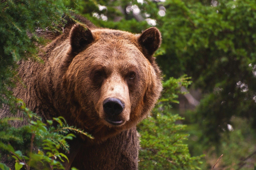

In [ ]:
from fastdownload import download_url
dest = 'bear.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [ ]:
!pip install duckduckgo_search


In [ ]:
from duckduckgo_search import DDGS
from fastdownload import download_url
from fastai.vision.all import *
import time
from pathlib import Path

# Search function
def search_images(term, max_images=30):
    print(f"Searching for '{term}'...")
    with DDGS() as ddgs:
        return L(ddgs.images(term, max_results=max_images)).itemgot('image')

# Download function
def download_images(dest, urls, max_pics=30):
    dest.mkdir(exist_ok=True)
    for i, url in enumerate(urls[:max_pics]):
        if i >= max_pics: break
        fname = dest/f'{i:03d}.jpg'
        try:
            download_url(url, fname, show_progress=False)
            print(f'Downloaded {url} to {fname}')
            time.sleep(0.1)
        except Exception as e:
            print(f'Error downloading {url}: {e}')
            if fname.exists(): fname.unlink()

# Main process
bear_types = ['grizzly', 'blue', 'gummy']
path = Path('bears')

for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    urls = search_images(f'{o} bear photo')
    download_images(dest, urls, max_pics=10)  # Reduced number of images

# Verify the results
fns = get_image_files(path)
print(f"Number of images downloaded: {len(fns)}")

Searching for 'grizzly bear photo'...
Downloaded https://www.publicdomainpictures.net/pictures/240000/velka/grizzly-bear-portrait-1511961987XRY.jpg to bears/grizzly/000.jpg
Downloaded https://www.goodfreephotos.com/albums/animals/mammals/grizzly-bear-in-the-wild.jpg to bears/grizzly/001.jpg
Downloaded https://wallpapers.com/images/file/grizzly-bear-pictures-2560-x-2048-o9hsfvsc9zfdzdu9.jpg to bears/grizzly/002.jpg
Downloaded https://d3d0lqu00lnqvz.cloudfront.net/media/media/897b2e5d-6d4c-40fa-bbe8-6829455747e2.jpg to bears/grizzly/003.jpg
Downloaded https://images.pexels.com/photos/162340/bear-bavarian-bear-wild-brown-bear-162340.jpeg?cs=srgb&dl=animal-bear-cute-162340.jpg&fm=jpg to bears/grizzly/004.jpg
Downloaded https://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly+Bear+Wildlife.jpg to bears/grizzly/005.jpg
Downloaded https://wallup.net/wp-content/uploads/2016/01/30094-bears-nature-animals-Grizzly_bear-Grizzly_Bears.jpg to bears/grizzly/006.jpg
Dow

In [ ]:
# First, verify your images actually downloaded
from pathlib import Path
path = Path('bears')

# Check how many images are in each directory
for bear_type in ['grizzly', 'blue', 'gummy']:
    bear_path = path/bear_type
    if bear_path.exists():
        files = list(bear_path.glob('*.jpg'))
        print(f"{bear_type}: {len(files)} images")
    else:
        print(f"{bear_type} directory doesn't exist")

grizzly: 10 images
blue: 10 images
gummy: 10 images


Our folder has image files, as we'd expect:

In [ ]:
fns = get_image_files(path)
fns

(#30) [Path('bears/blue/005.jpg'),Path('bears/blue/002.jpg'),Path('bears/blue/000.jpg'),Path('bears/blue/009.jpg'),Path('bears/blue/003.jpg'),Path('bears/blue/001.jpg'),Path('bears/blue/004.jpg'),Path('bears/blue/006.jpg'),Path('bears/blue/007.jpg'),Path('bears/blue/008.jpg'),Path('bears/gummy/005.jpg'),Path('bears/gummy/002.jpg'),Path('bears/gummy/000.jpg'),Path('bears/gummy/009.jpg'),Path('bears/gummy/003.jpg'),Path('bears/gummy/001.jpg'),Path('bears/gummy/004.jpg'),Path('bears/gummy/006.jpg'),Path('bears/gummy/007.jpg'),Path('bears/gummy/008.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [ ]:
failed = verify_images(fns)
failed

(#1) [Path('bears/blue/000.jpg')]

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [ ]:
# Add missing_ok=True to handle files that might already be gone
for f in failed:
    try:
        f.unlink(missing_ok=True)  # This will not raise an error if file is already gone
    except Exception as e:
        print(f"Could not remove {f}: {e}")

# Now let's check what we have left
fns = get_image_files(path)
print(f"\nRemaining valid images: {len(fns)}")


Remaining valid images: 29


In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(size=128)
    )

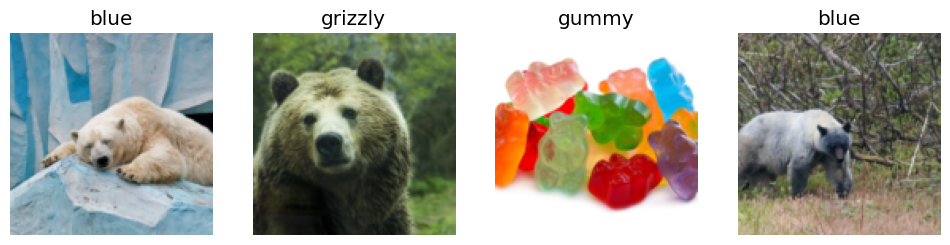

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

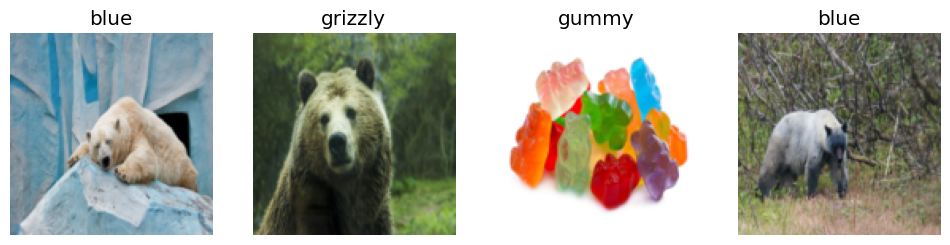

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

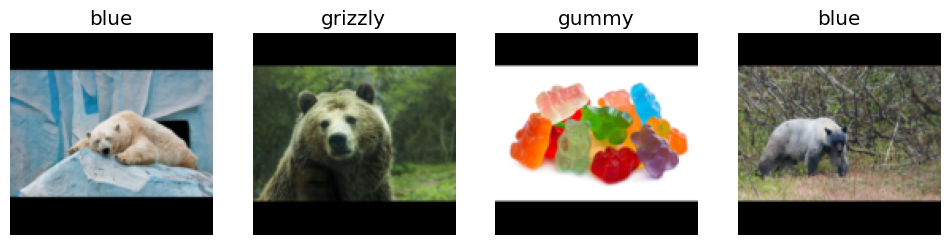

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

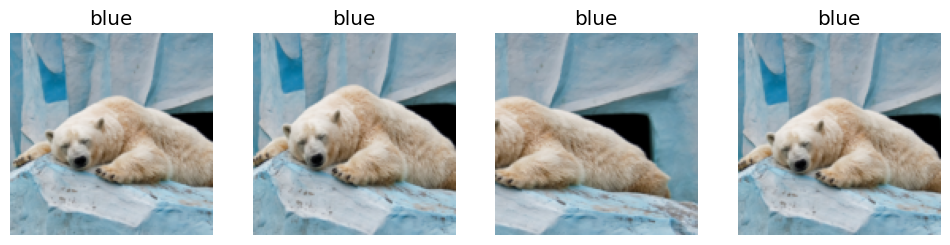

In [ ]:
# Simplified DataBlock
bears_simple = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128,  min_scale=0.3))

# Create dataloaders with minimal batch size
dls_simple = bears_simple.dataloaders(path, bs=4)

dls_simple.train.show_batch(max_n=4,nrows=1,unique=True)

We used `unique=True` to have the same image repeated with different versions of this `RandomResizedCrop` transform. This is a specific example of a more general technique, called data augmentation.

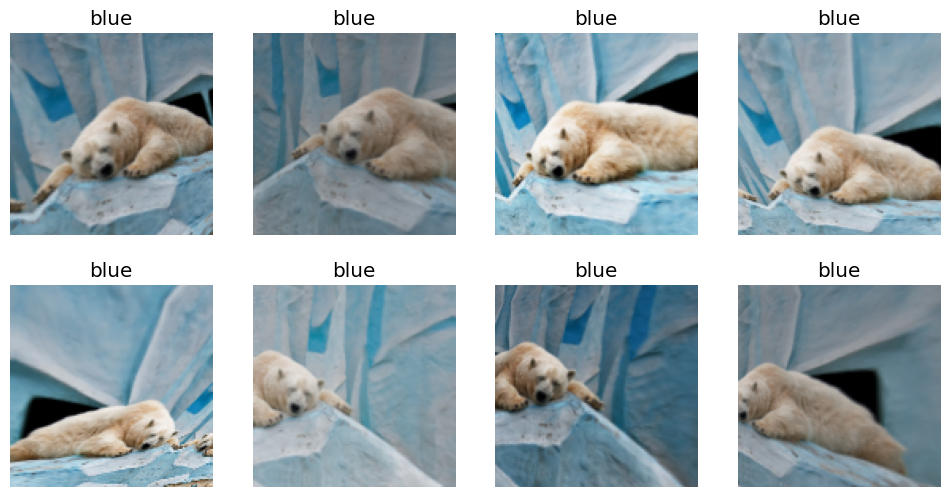

In [ ]:
bears_augment = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))

dls = bears_augment.dataloaders(path, bs=16)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path, bs=29)

We can now create our `Learner` and fine-tune it in the usual way:

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.11/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a *confusion matrix*:

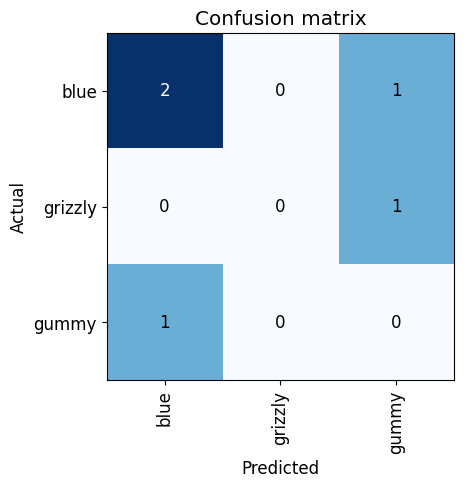

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

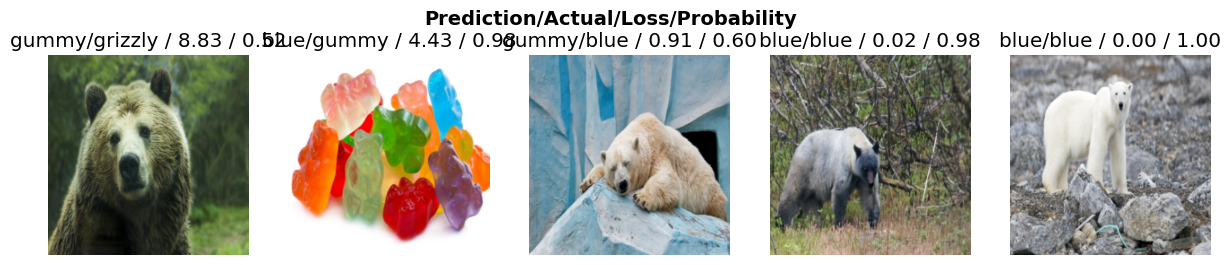

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(size=128)
)

# Create dataloaders
dls = bears.dataloaders(path)

# Then set the vocabulary explicitly
dls.vocab = ['grizzly', 'blue', 'gummy']  # Set in the order you want

# Now train with these dataloaders
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)
learn.export('bears_fixed.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


/usr/local/lib/python3.11/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


removed


In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('bears.pkl'),Path('bears_fixed.pkl')]

In [ ]:
learn_inf = load_learner('bears.pkl')
print(learn_inf.dls.vocab)

['blue', 'grizzly', 'gummy']


In [ ]:
learn_inf.predict('bears/grizzly/003.jpg')

('blue', tensor(0), tensor([9.3035e-01, 1.2530e-04, 6.9525e-02]))

In [ ]:
learn_inf.dls.vocab

['blue', 'grizzly', 'gummy']

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

<img alt="An upload button" width="159" src="https://github.com/fastai/fastbook/blob/master/images/att_00008.png?raw=1">

Now we can grab the image:

In [ ]:
img = PILImage.create(btn_upload.data[-1])

We can use an `Output` widget to display it:

In [ ]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: blue; Probability: 0.7918')

In [ ]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
#hide_output
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post.